To view the LaTeX equations correctly rendered, it is better to [open this notebook in nbviewer](http://nbviewer.jupyter.org/github/alvipe/Mumai/blob/master/Gesture%20classification/emg_classification.ipynb).

First, we have to import the required modules:
* **NumPy** is used to work with arrays and matrices and to use some mathematical functions, as well as to load the EMG dataset.
* **scikit-learn** to perform the dimensionality reduction and scaling of the feature matrix (with the linear discriminant analysis and the min-max scaling methods, respectively) and to implement the classifier (a multiclass support vector machine), as well as to randomly split data into train and test data.
* **matplotlib** is used to plot data.

In [1]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

The EMG dataset is stored in a .npy file, so the numpy.load function is used to load the data. We set the number of recorded gestures (nGestures), the number of EMG channels (nChannels), the number of times each gesture was repeated during the recording session (nIterations) and the total number of signals (nSignals).

In [2]:
emg_data = np.load('emg_data_5class_2channel.npy').item()
nGestures = 5
nIterations = 5
nChannels = 2
nSignals = nGestures*nIterations*nChannels
emg = []
segmented_emg = []

The EMG signals are stored as a list of arrays in the following manner: signals corresponding to the same motion are grouped toghether

[motion1_channel1_iter1, motion1_channel2_iter1, motion1_channel1_iter2, motion1_channel2_iter2,..., motion2_channel1_iter1, motion2_channel2_iter1,...,motion5_channel2_iter5]

In [3]:
for m in range(1,nGestures+1):
    for i in range(nIterations):
        for c in range(1,nChannels+1):
            emg.append(emg_data['motion'+str(m)+'_ch'+str(c)][:,i])

##Data segmentation

The raw EMG signals could be used to train the classifier, but classifiers often perform better when they are fed with a set of meaningful features that describe some properties of the data. Before computing the features of the EMG data, the signals have to be segmented, that is, they have to be divided into chunks with a predefined length. There are two methods of EMG segmentation: disjoint and overlapped segmentation [1]. The first method is implemented here with the following function, which takes one EMG signal and generates a 2D matrix where the columns are the segments in which the signal is divided and the rows are the samples of each segment.

In [4]:
def segmentation(emg, samples = 150):
    N = samples # number of samples per segment
    S = int(np.floor(emg.shape[0]/N)) # number of segments
    length = 0
    segmented_emg = np.zeros((N,S))
    for s in range(S):
        for n in range(length,N+length):
            segmented_emg[n-length,s] = emg[n] # NxS matrix with a EMG signal divided in s segments, each one with n samples
        length = length + N
    length = 0
    return segmented_emg

We execute the segmentation function for each EMG signal in the dataset, to generate a list containing all the segmented signals.

In [5]:
for n in range(nSignals):
    segmented_emg.append(segmentation(emg[n]))

##Feature extraction

The features that are going to be computed are some of the time domain features described in [2]. These features are commongly used in EMG feature extraction because they are easy to compute and give meaningful information regarding the amplitude, frequency and duration of the signal.

**Mean absolute value:** it gives information about muscle contraction levels. It is defined as

\begin{equation}
MAV_{k} = \dfrac{1}{N} \sum\limits_{i=1}^{N} \vert x_{i} \vert
\end{equation}

In [6]:
def mav(segment):
    mav = np.mean(np.abs(segment))
    return mav

**Root mean square:** it reflects the mean power of the signal and is related to the constant force and non-fatiguing contraction. It is defined as

\begin{equation}
RMS_{k} = \sqrt{\dfrac{1}{N} \sum\limits_{i=1}^{N} x_{i}^{2}}
\end{equation}

In [7]:
def rms(segment):
    rms = np.sqrt(np.mean(np.power(segment,2)))
    return rms

**Variance:** it is a measure of the power density of the signal. It is defined as

\begin{equation}
VAR_{k} = \dfrac{1}{N} \sum\limits_{i=1}^{N}\left(x_{i}-\overline{x}\right)^{2}
\end{equation}

In [8]:
def var(segment):
    var = np.var(segment)
    return var

**Simple square integral:** it gives a measure of the energy of the EMG signal. It is defined as

\begin{equation}
SSI_{k} = \sum\limits_{i=1}^{N}\left(\vert x_{i}^{2} \vert\right)
\end{equation}

In [9]:
def ssi(segment):
    ssi = np.sum(np.abs(np.power(segment,2)))
    return ssi

**Zero crossings:** it is the number of times the waveform crosses zero. This feature provides an approximate estimation of frequency domain properties. The threshold avoids counting zero crossings induced by noise. It is calculated as follows

Increment one unit the zero crossings count value if

\begin{equation}
\left\lbrace x_{i} > 0 \space and \space x_{i+1} < 0 \right\rbrace \space or \space \left\lbrace x_{i} < 0 \space and \space x_{i+1} > 0 \right\rbrace \space and \space \vert x_{i} - x_{i+1} \vert \geq threshold
\end{equation}

Which can be rewritten as:

\begin{equation}
ZC_{k} = \sum\limits_{i=1}^{N-1} \left\lbrace f \left( x_{i}*x_{i+1}\right) \right\rbrace;\\
f(x) = 1, \space if \space x < 0 \space and \space \vert x_{i} - x_{i+1} \vert \geq threshold\\
f(x) = 0, \space otherwise
\end{equation}

This expression has one problem: given three consecutive data points $x_{i-1} > 0$, $x_{i} = 0$ and $x_{i+1} < 0$, the waveform has crossed zero but the zero crossing count is not incremented. If $x_{i}*x_{i+1} \leq 0$ is used instead of $x_{i}*x_{i+1} < 0$, the zero crossing is counted twice. The code that computes the zero crossings takes all this into account, and solves it by taking only the nonzero values of the segments, as shown below.

In [10]:
def zc(segment):
    nz_segment = []
    nz_indices = np.nonzero(segment)[0] #Finds the indices of the segment with nonzero values
    for m in nz_indices:
        nz_segment.append(segment[m]) #The new segment contains only nonzero values    
    N = len(nz_segment)
    zc = 0
    for n in range(N-1):
        if((nz_segment[n]*nz_segment[n+1]<0) and np.abs(nz_segment[n]-nz_segment[n+1]) >= 0.001):
            zc = zc + 1
    return zc

**Waveform length:** it is the cumulative length of the waveform over the segment. This feature is related to the signal amlitude, frequency and time. It is defined as

\begin{equation}
WL_{k} = \sum\limits_{i=1}^{N-1} \vert x_{i+1} - x_{i} \vert
\end{equation}

In [11]:
def wl(segment):
    wl = np.sum(np.abs(np.diff(segment)))
    return wl

**Slope sign changes:** it is similar to the zero crossings feature. It also provides information about the frequency content of the signal. It is calculated as follows

Increment one unit the slope sign change value if

\begin{equation}
\left\lbrace x_{i} > x_{i-1} \space and \space x_{i} > x_{i+1} \right\rbrace \space or \space \left\lbrace x_{i} < x_{i-1} \space and \space x_{i} < x_{i+1} \right\rbrace \space and \space \vert x_{i}-x_{i+1} \vert \geq threshold \space or \space \vert x_{i}-x_{i-1} \vert \geq threshold
\end{equation}

Which can be rewritten as:

\begin{equation}
SSC_{k} = \sum\limits_{i=2}^{N-1} \left[ f \left[ \left( x_{i}-x_{i-1} \right)* \left( x_{i}-x_{i+1} \right) \right] \right];\\
f(x) = 1, \space if \space x \geq threshold\\
f(x) = 0, \space otherwise
\end{equation}

In [12]:
def ssc(segment):
    N = len(segment)
    ssc = 0
    for n in range(1,N-1):
        if (segment[n]-segment[n-1])*(segment[n]-segment[n+1])>=0.001:
            ssc = ssc + 1
    return ssc

**Willison amplitude:** it is the number of times that the difference of the amplitude between to adjacent data points exceed a predefined threshold. This feature provides information about the muscle contraction level. It is defined as

\begin{equation}
WAMP_{k} = \sum\limits_{i=1}^{N-1} f(\vert x_i-x_{i+1} \vert);\\
f(x) = 1, \space if \space x \geq threshold\\
f(x) = 0, \space otherwise
\end{equation}

In [13]:
def wamp(segment):
    N = len(segment)
    wamp = 0
    for n in range(N-1):
        if np.abs(segment[n]-segment[n+1])>=50:
            wamp = wamp + 1
    return wamp

We define a list containing the above functions, to execute them one after another in a for loop.

In [14]:
feature_list = [mav, rms, var, ssi, zc, wl, ssc, wamp]

In [15]:
def features(segment,feature_list):
    features = np.zeros((1,len(segment)*len(feature_list)))
    i = 0
    for feature in feature_list:
        features[0,i] = feature(segment[0])
        features[0,i+1] = feature(segment[1])
        i = i + len(segment)
    return features

In [16]:
nFeatures = len(feature_list)
nSegments = len(segmented_emg[0][0])

feature_matrix = np.zeros((nGestures*nIterations*nSegments,nFeatures*nChannels))
n = 0

for i in range(0,nSignals,nChannels):
    for j in range(nSegments):
        feature_matrix[n] = features((segmented_emg[i][:,j],segmented_emg[i+1][:,j]),feature_list)
        n = n + 1

Besides generating the feature matrix that is going to be used to train the classifier, we have to generate the target matrix, that is, the matrix containing the different classes corresponding to the recorded gestures. The target matrix is needed at this point to be able to perform the next step, dimensionality reduction, since the employed method requires the classes of the data to be reduced. In this case where we have five classes, the target matrix is an array in which each class is represented by a number ranging from 0 to 4.

In [17]:
def gestures(nSamples,nGestures):
    gestures = []
    for m in range(nGestures):
        gestures.append((m*np.ones((nSamples))))
    gestures = np.array(gestures).ravel()
    return gestures

In [18]:
y = gestures(nSegments*nIterations,nGestures)

##Dimensionality reduction and feature scaling

The feature matrix that we have generated has 16 dimensions (eight features for each of the two EMG measurement channels). We could use this feature matrix to train our gesture classifier, but we can improve its performance by reducing the number of dimensions while keeping the relevant information. According to [3], there are two ways of performing this step: feature projection and feature selection. The latter method reduces the number of features by selecting the best subset of the original set, according to some criterion. In this case, we are going to implement the first method, which determines the best combination of the original features.

Feature projection is generally performed using Principal Component Analysis (PCA) or Linear Discriminant Analysis (LDA). PCA is usually used in unsupervised learning tasks and works by projecting data into a subspace by retaining those characteristics of the dataset that contribute most to its variance. On the other hand, LDA is used in supervised learning tasks and its objective is to find a data projection that maximizes the separation between classes. In this case, we are going to use LDA to reduce the dimensions of the feature matrix from 16 to 2.

Besides dimensionality reduction, it is advisable to standarize the range of the feature values. Depending on the employed machine learning algorithm, if the value of any of the features varies greatly, this feature can dominate over the rest and negatively influence the performance of the algorithm. For this reason, the range of all features is normalized so that each one contributes proportionately during training. To this end, the simplest method is rescaling the range of features to a new range of [0,1] or [-1,1] with the min-max algorithm.

The following function implements the described steps: dimensionality reduction with LDA and feature scaling in the range [-1,1] with min-max. Besides returning the reduced and scaled feature matrix, it also returns the fitted reduction and scaling models, so that they can be applied to new data.

In [19]:
def feature_scaling(feature_matrix,target,reductor=None,scaler=None):
    lda = LDA(n_components=2)    
    minmax = MinMaxScaler(feature_range=(-1,1))
    if not reductor:
        reductor = lda.fit(feature_matrix,target)
    feat_lda = reductor.transform(feature_matrix)
    if not scaler:
        scaler = minmax.fit(feat_lda)
    feat_lda_scaled = scaler.transform(feat_lda)
    
    return feat_lda_scaled,reductor,scaler

In [20]:
[X,reductor,scaler] = feature_scaling(feature_matrix, y)

At this point, since the new feature matrix has two dimensions, it can be visualized in a scatter plot.

c:\python27\lib\site-packages\matplotlib\collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


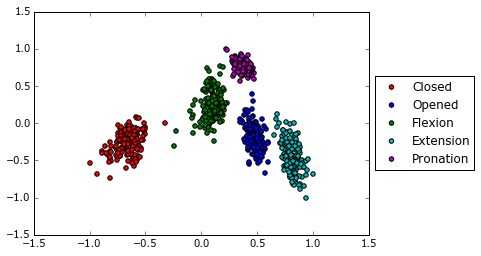

In [21]:
plt.scatter(X[0:nSegments*nIterations,0],X[0:nSegments*nIterations,1],c='r',label='Closed')
plt.scatter(X[nSegments*nIterations:2*nSegments*nIterations,0],X[nSegments*nIterations:2*nSegments*nIterations,1],c='b',label='Opened')
plt.scatter(X[2*nSegments*nIterations:3*nSegments*nIterations,0],X[2*nSegments*nIterations:3*nSegments*nIterations,1],c='g',label='Flexion')
plt.scatter(X[3*nSegments*nIterations:4*nSegments*nIterations,0],X[3*nSegments*nIterations:4*nSegments*nIterations,1],c='c',label='Extension')
plt.scatter(X[4*nSegments*nIterations:5*nSegments*nIterations,0],X[4*nSegments*nIterations:5*nSegments*nIterations,1],c='m',label='Pronation')
plt.legend(scatterpoints=1,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.scatter(feat_scaled[:,0],feat_scaled[:,1],c=target)
#plt.show()

Five distinct point clusters, corresponding to the five recorded gestures, can be seen. With these data, the classifier will not have any problem in computing the decision boundaries, and probably the classification accuracy will be near a 100%.

##Classification

Before training the classifier, we are going to randomly divide the feature and target matrices into training and testing sets. This is done to avoid overfitting the model: by using the training set only to fit the model and the testing set to validate its performance, we ensure that the model is able to correctly classify new, completely unknown, data.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Now, we are ready to build and train our classifier. As said before, we are going to use a multiclass support vector machine (SVM). SVMs 

In [23]:
classifier = SVC(kernel='rbf',C=10,gamma=10)
classifier.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Test the classifier. We take the last iteration of each recorded gesture. We execute the same steps to have the scaled feature matrix (data loading -> segmentation -> feature calculation -> target matrix generation -> feature scaling)

In [24]:
predict = classifier.predict(X_test)
print("Classification accuracy = %0.2f percent." %(100*classifier.score(X_test,y_test)))

Classification accuracy = 99.38 percent.


As expected, the achieved classification accuracy is very high, near a perfect score.

##Apendix: optimization of the SVM parameters with cross validation

Code taken and adapted from [here](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

```python
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

C_range = np.logspace(-5,5,11)
gamma_range = np.logspace(-30,1,32)
param_grid = dict(gamma=gamma_range,C=C_range)
cv = StratifiedShuffleSplit(y, n_iter=20,test_size=0.2,random_state=42)
grid = GridSearchCV(SVC(),param_grid=param_grid,cv=cv)
grid.fit(X,y)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_,grid.best_score_))
```

##References

[1] M.A. Oskoei and H. Hu, Support vector machine-based classification scheme for myoelectric control applied to
upper limb. *IEEE Transactions on Biomedical Engineering*, 55(8), pp. 1956–1965, 2008.

[2] E.J. Rechy-Ramirez and H. Hu, Stages for developing control systems using EMG and EEG signals: a survey, *Technical report*, School of Computer Science and Electronic Engineering, University of Essex, 2011.

[3] K. Englehart, Signal representation for classification of the transient myoelectric signal, *PhD thesis*, University of New Brunswick, 1998.